## Image Classifier Training
1. CIFAR10 dataset loading and normalizing
2. CNN 정의
3. Loss function 정의
4. Train CNN with training data
5. Test CNN with test data

### 1. CIFAR10 dataset loading and normalizing

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image 확인

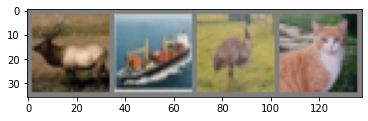

deer      ship      bird      cat       


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join(f"{classes[labels[j]]:10s}" for j in range(4)))

### 2. CNN 정의
- 2개의 convolution층과 3개의 fc층을 통과하는 CNN을 구성한다

In [4]:
import torch.nn as nn
import torch.nn.functional as F

USE_CUDA = True

if USE_CUDA:
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print(device)
    if device == 'cpu':
        USE_CUDA = False
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
if USE_CUDA:
    net.to(device)

cuda:0


### 3. Loss Function 정의
- 분류이므로 CrossEntropy를 사용한다
- 최적화 방식은 SGD + momentum을 사용한다

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train CNN with training data

In [6]:
for epoch in range(2):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if USE_CUDA:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"{epoch+1} {i+1:5d} loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print('Training Finished.')

1  2000 loss: 2.204
1  4000 loss: 1.849
1  6000 loss: 1.666
1  8000 loss: 1.585
1 10000 loss: 1.505
1 12000 loss: 1.481
2  2000 loss: 1.393
2  4000 loss: 1.358
2  6000 loss: 1.356
2  8000 loss: 1.328
2 10000 loss: 1.319
2 12000 loss: 1.279
Training Finished.


Model 저장

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test CNN with test data

In [8]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acc. of the network on the 10000 test images: {100 * correct / total : .3f}")

Acc. of the network on the 10000 test images:  55.120


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f"Acc. of {classes[i]:5s} : {100*class_correct[i] / class_total[i]:.3f}")

Acc. of plane : 50.800
Acc. of car   : 74.500
Acc. of bird  : 34.700
Acc. of cat   : 36.500
Acc. of deer  : 49.600
Acc. of dog   : 49.900
Acc. of frog  : 58.400
Acc. of horse : 59.200
Acc. of ship  : 65.400
Acc. of truck : 72.200
